## Import các thư viện cần thiết

In [66]:
from sklearn.utils import shuffle
import numpy as np

## Import dữ liệu

In [67]:
# Load bộ dữ liệu mnist của keras
with np.load('input/mnist-dataset/mnist.npz') as f:
    X_train, y_train  = f['x_train'], f['y_train']
    X_test, y_test = f['x_test'], f['y_test']
    
    # Thiết lập số lượng mẫu dùng để huấn luyện và kiểm tra, ở đây chỉ sử dụng kích thước mẫu huấn luyện có kích tước 30000 và mẫu kiểm tra có kích thước 10000 để tăng thời gian huấn luyện
    num_train_samples = 30000
    num_test_samples = 10000
    
    # Lấy mẫu dữ liệu huấn luyện và kiểm tra
    X_train, y_train = X_train[:num_train_samples], y_train[:num_train_samples]
    X_test, y_test = X_test[:num_test_samples], y_test[:num_test_samples]

In [68]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (30000, 28, 28)
Y_train: (30000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


## Triển khai mô hình CNN

### Convolution 3x3

In [69]:
class Conv3x3:
    '''
        Lớp Convolution sử dụng bộ lộc có kích thước 3x3
    '''
    
    '''
        Hàm khởi tạo
        - num_filters: số lượng bộ lọc
        - filters: mảng 3d với kích thước (num_filters, 3, 3). Chúng ta chia cho 9 để giảm phương sai của các giá trị ban đầu giúp cho dữ liệu tập trung giá trị trung bình
    '''
    def __init__(self, num_filters):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    def iterate_regions(self, image):
        # Lấy height và width của ảnh
        h, w = image.shape
        
        # Lặp qua các vị trí của ảnh
        '''
            Do lặp từ trái qua phải và từ trên xuống dưới bằng vùng ảnh 3x3 nên khi đến bìa phải và dưới cùng thì nó dư ra 2 cell và không còn chỗ chứa nên phải trừ đi 2 cell dư đó
        '''
        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j
    
    # Lan truyền thẳng
    def forward(self, input):
        '''
            Hàm này sẽ trả về một mảng 3D với kích thước (h - 2, w - 2, self.num_filters) sau khi áp dụng các bộ lọc.
        '''
        # Lưu lại input để sử dụng cho lan truyền ngược
        self.last_input = input

        # Lấy height và width của ảnh
        h, w = input.shape
        
        # Khởi tạo một mảng 3D với kích thước (h - 2, w - 2, self.num_filters) để lưu kết quả sau khi áp dụng các bộ lọc.
        output = np.zeros((h - 2, w - 2, self.num_filters))

        # Tích chập ảnh với các bộ lọc
        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
        
        # Trả về kết quả
        return output

    # Lan truyền ngược
    def backprop(self, d_L_d_out, learn_rate):
        '''
            Hàm này sẽ cập nhật các bộ lọc dựa trên gradient của hàm mất mát theo đầu ra của lớp Convolution.
            - d_L_d_out là gradient của hàm mất mát theo đầu ra của lớp Convolution.
            - learn_rate là tốc độ học.
        '''
        
        # Khởi tạo một mảng với cùng kích thước với các bộ lọc (filters) để lưu gradient của hàm mất mát (loss function) theo các bộ lọc.
        d_L_d_filters = np.zeros(self.filters.shape)
        
        # Lặp qua từng vùng 3x3 pixel của ảnh đầu vào mà lớp Convolution đã lưu lại trong quá trình lan truyền thẳng.
        for im_region, i, j in self.iterate_regions(self.last_input):
            # Lặp qua từng bộ lọc. 
            for f in range(self.num_filters):
                # Tính toán gradient của hàm mất mát theo từng bộ lọc. d_L_d_out[i, j, f] là gradient của hàm mất mát theo đầu ra của lớp Convolution tại vị trí (i, j) và bộ lọc thứ f. im_region là vùng ảnh 3x3 tương ứng.
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Cập nhật giá trị của các bộ lọc (Cập nhật trọng số) dựa trên gradient vừa tính toán. learn_rate là tốc độ học, một hệ số dùng để kiểm soát mức độ cập nhật của các bộ lọc.
        self.filters -= learn_rate * d_L_d_filters

        # Phương thức này không trả về gì cả, vì lớp Convolution này được sử dụng như là lớp đầu tiên trong mạng CNN. Khi đến lớp MaxPool thì chúng ta mới sẽ cần trả về gradient của hàm mất mát theo đầu vào của lớp này, giống như các lớp khác trong mạng CNN.
        return None


### MaxPool 2x2

In [70]:
class MaxPool2:
    '''
        Lớp Max Pooling với kích thước 2x2.
    '''

    def iterate_regions(self, image):
        '''
            Tạo ra các vùng 2x2 không chồng lên nhau trên hình ảnh đầu vào.
            - image là một mảng numpy 2D.
        '''
        
        # Lấy chiều cao và chiều rộng của hình ảnh đầu vào. 
        h, w, _ = image.shape
        
        # Tính toán chiều cao và chiều rộng mới cho hình ảnh sau khi áp dụng Max Pooling. Do Max Pooling với kích thước 2x2 sẽ giảm kích thước của hình ảnh xuống một nửa. 
        new_h = h // 2
        new_w = w // 2
        
        # Lặp qua từng vị trí trên hình ảnh sau khi áp dụng Max Pooling. 
        for i in range(new_h):
            for j in range(new_w):
                # Lấy một vùng 2x2 từ hình ảnh đầu vào tại vị trí tương ứng.
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                # Trả về vùng ảnh 2x2 và vị trí của nó trên hình ảnh sau khi áp dụng Max Pooling.
                yield im_region, i, j

    # Lan truyền thẳng
    def forward(self, input):
        '''
            Thực hiện lan truyền thẳng bằng các input đã cho.
            Trả về mảng 3d với kích thước (h / 2, w / 2, num_filters).
            - input là mảng 3 chiều với các kích thước (h, w, num_filters)
        '''
        # Lưu lại đầu vào cho lớp Max Pooling để sử dụng cho lan truyền ngược.
        self.last_input = input

        # Lấy chiều cao, chiều rộng và số lượng bộ lọc từ đầu vào.
        h, w, num_filters = input.shape
        
        # Khởi tạo một mảng 3D với kích thước (h / 2, w / 2, num_filters) để lưu kết quả sau khi áp dụng Max Pooling. Kích thước của hình ảnh sẽ giảm xuống một nửa sau khi áp dụng Max Pooling với kích thước 2x2.
        output = np.zeros((h // 2, w // 2, num_filters))
        
        # Lặp qua từng vùng 2x2 trên hình ảnh đầu vào.
        for im_region, i, j in self.iterate_regions(input):
            # Tính giá trị lớn nhất trong mỗi vùng 2x2 và gán vào mảng output tại vị trí tương ứng.
            output[i, j] = np.amax(im_region, axis=(0, 1))
        
        # Trả về kết quả sau khi áp dụng Max Pooling.
        return output

    def backprop(self, d_L_d_out):
        '''
            Thực hiện lan truyền ngược bằng gradient của hàm mất mát theo đầu ra của lớp Max Pooling.
            Trả về gradient của hàm mất mát theo đầu vào của lớp Max Pooling.
            - d_L_d_out là gradient của hàm mất mát theo đầu ra của lớp Max Pooling.
        '''
        
        # Khởi tạo một mảng với cùng kích thước với đầu vào của lớp Max Pooling để lưu gradient của hàm mất mát theo đầu vào.
        d_L_d_input = np.zeros(self.last_input.shape)

        # Lặp qua từng vùng 2x2 trên hình ảnh đầu vào mà lớp Max Pooling đã lưu lại trong quá trình lan truyền thẳng.
        for im_region, i, j in self.iterate_regions(self.last_input):
            # Lấy chiều cao, chiều rộng và số lượng bộ lọc từ vùng ảnh. 
            h, w, f = im_region.shape
            
            # Tính giá trị lớn nhất trong mỗi vùng ảnh 2x2.
            amax = np.amax(im_region, axis=(0, 1))

            # Lặp qua từng pixel và từng bộ lọc trong vùng ảnh.
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # Kiểm tra xem pixel này có phải là giá trị lớn nhất trong vùng ảnh không.
                        # Nếu pixel này là giá trị lớn nhất, thì copy gradient của hàm mất mát theo đầu ra của lớp Max Pooling tại vị trí tương ứng vào mảng d_L_d_input.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]
        # Trả về gradient của hàm mất mát theo đầu vào của lớp Max Pooling.
        return d_L_d_input

## Triển khai lớp Softmax

In [71]:
class Softmax: # Activation function
    '''
        A standard fully-connected layer with softmax activation.
    '''

    def __init__(self, input_len, nodes):
        # Trọng số được khởi tạo ngẫu nhiên theo phân phối chuẩn (Gaussian distribution) với kích thước (input_len, nodes). Chúng được chia cho input_len để giảm phương sai của các giá trị khởi tạo, giúp cho quá trình học tập ổn định hơn
        self.weights = np.random.randn(input_len, nodes) / input_len
        # Độ lệch được khởi tạo là một mảng có kích thước bằng số lượng nơ-ron trong lớp Softmax và tất cả các giá trị ban đầu đều là 0.
        self.biases = np.zeros(nodes)

    def forward(self, input):
        '''
            Thực hiện lan truyền thẳng lớp Softmax với đầu vào input.
            Trả về một mảng numpy 1 chiều chứa xác suất của từng lớp.
            Đầu vào có thể là một mảng ở bất kỳ kích thước nào.
        '''
        
        # Lưu lại input để sử dụng cho lan truyền ngược
        self.last_input_shape = input.shape
        
        # Chuyển đổi đầu vào thành một mảng một chiều. Điều này cần thiết vì lớp Softmax nhận đầu vào dưới dạng một vector.
        input = input.flatten()
        
        # Lưu lại đầu vào đã được làm phẳng để sử dụng cho lan truyền ngược
        self.last_input = input

        # Lấy kích thước của ma trận trọng số. input_len là số lượng đầu vào và nodes là số lượng nơ-ron trong lớp Softmax.
        input_len, nodes = self.weights.shape

        # Tính tổng trọng số của đầu vào. Đây là bước tính toán tổng trọng số (weighted sum) trong mạng nơ-ron. 
        totals = np.dot(input, self.weights) + self.biases
        
        # Lưu lại tổng trọng số để sử dụng cho lan truyền ngược
        self.last_totals = totals
        
        # Tính hàm mũ e cho mỗi giá trị trong tổng trọng số. Đây là bước đầu tiên của hàm kích hoạt Softmax.
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        '''
            Tiến hành thực hiện lan truyền ngược trên lớp Softmax.
            Trả về gradient mất mát cho đầu vào của lớp này.
            - d_L_d_out là gradient của hàm mất mát theo đầu ra của lớp Softmax.
            - learn_rate là tốc độ học.
        '''
        # We know only 1 element of d_L_d_out will be nonzero
        
        # Lặp qua từng gradient trong d_L_d_out, đây là gradient của hàm mất mát theo đầu ra của lớp Softmax.
        for i, gradient in enumerate(d_L_d_out):
            # Nếu gradient bằng 0, bỏ qua lần lặp hiện tại và tiếp tục với lần lặp tiếp theo. 
            if gradient == 0:
                continue

            # e^totals. Tính hàm mũ e cho tổng trọng số đã được lưu lại trong quá trình lan truyền thẳng. 
            t_exp = np.exp(self.last_totals)

            # Tính tổng của tất cả các giá trị t_exp hay e^totals
            S = np.sum(t_exp)

            # Tính gradient của đầu ra tại vị trí i theo tổng trọng số.
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            # Cập nhật gradient của đầu ra tại vị trí i theo tổng trọng số.
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Gradients của tổng trọng số so với weights/biases/input
            # Gradient của tổng trọng số theo trọng số là input cuối cùng
            d_t_d_w = self.last_input
            # Gradient của tổng trọng số theo bias là 1.
            d_t_d_b = 1
            # Gradient của tổng trọng số theo đầu vào là weights.
            d_t_d_inputs = self.weights

            # Tính gradient của hàm mất mát theo tổng trọng số.
            d_L_d_t = gradient * d_out_d_t

            # Gradients của tổng trọng số so với weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            # Cập nhật trọng số và bias dựa trên gradient của loss func và learning_rate. 
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b
            
        # Trả về gradient của hàm mất mát theo đầu vào, đã được định hình lại để phù hợp với kích thước của đầu vào ban đầu
        return d_L_d_inputs.reshape(self.last_input_shape)

## Huấn luyện mô hình

In [72]:
def forward(image, label):
    '''
        Hoàn thành quá trình lan truyền thẳng của CNN và tính toán độ chính xác và cross-entropy loss.
         - hình ảnh là một mảng numpy 2d
         - nhãn là một chữ số
    '''
    # Đầu tiên, hình ảnh được chuyển đổi từ phạm vi [0, 255] về phạm vi [-0.5, 0.5] để dễ dàng xử lý hơn. Sau đó, hình ảnh được truyền qua lớp Convolution.
    out = conv.forward((image / 255) - 0.5)
    
    # Đầu ra từ lớp Convolution sau đó được truyền qua lớp Max Pooling.
    out = pool.forward(out)
    
    # Đầu ra từ lớp Max Pooling sau đó được truyền qua lớp Softmax.
    out = softmax.forward(out)

    # Tính toán mất mát cross-entropy. out[label] là xác suất mà mô hình dự đoán cho nhãn đúng, và np.log() là hàm logarit tự nhiên.
    loss = -np.log(out[label])
    
    # Tính toán độ chính xác. Nếu nhãn dự đoán bởi mô hình (nhãn có xác suất cao nhất) trùng với nhãn thực tế, thì độ chính xác là 1, ngược lại là 0.
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=0.005):
    '''
    Completes a full training step on the given image and label.
    Returns the cross-entropy loss and accuracy.
    - image is a 2d numpy array
    - label is a digit
    - lr is the learning rate
    '''
    # Lan truyền thẳng
    out, loss, acc = forward(im, label)

    # Khởi tạo một gradient ban đầu là một mảng có 10 phần tử, tất cả đều là 0. Mảng này tương ứng với gradient của hàm mất mát theo đầu ra của lớp Softmax.
    gradient = np.zeros(10)
    
    # Cập nhật gradient tại vị trí tương ứng với nhãn đúng. Đây là gradient của hàm mất mát cross-entropy theo đầu ra của lớp Softmax.
    gradient[label] = -1 / out[label]

    # Lan truyền ngược
    # Thực hiện lan truyền ngược qua lớp Softmax bằng cách sử dụng gradient đã tính và tốc độ học. Hàm backprop của lớp Softmax trả về gradient của hàm mất mát theo đầu vào của lớp này.
    gradient = softmax.backprop(gradient, lr)
    
    # Thực hiện lan truyền ngược qua lớp Max Pooling bằng cách sử dụng gradient từ lớp Softmax. Hàm backprop của lớp Max Pooling trả về gradient của hàm mất mát theo đầu vào của lớp này.
    gradient = pool.backprop(gradient)
    
    # Thực hiện lan truyền ngược qua lớp Convolution bằng cách sử dụng gradient từ lớp Max Pooling và tốc độ học. Hàm backprop của lớp Convolution trả về gradient của hàm mất mát theo đầu vào của lớp này.
    gradient = conv.backprop(gradient, lr)
    
    # Trả về mất mát cross-entropy và độ chính xác cho bước huấn luyện này.
    return loss, acc

In [73]:
# 28x28x1 -> 26x26x8
# Khởi tạo một lớp Convolution với 8 bộ lọc. Lớp Convolution sẽ áp dụng các bộ lọc này lên hình ảnh đầu vào, giúp trích xuất các đặc trưng cục bộ từ hình ảnh. Kích thước của hình ảnh sau khi đi qua lớp này sẽ từ 28x28x1 (đầu vào) trở thành 26x26x8 (đầu ra). 
conv = Conv3x3(8)

# 26x26x8 -> 13x13x8
# Khởi tạo một lớp Max Pooling với kích thước 2x2. Lớp Max Pooling giúp giảm kích thước của hình ảnh đầu vào bằng cách lấy giá trị lớn nhất trong mỗi vùng 2x2. Kích thước của hình ảnh sau khi đi qua lớp này sẽ từ 26x26x8 (đầu vào) trở thành 13x13x8 (đầu ra). 
pool = MaxPool2()

# 13x13x8 -> 10
# Khởi tạo một lớp Softmax, đây là lớp cuối cùng của mạng. Lớp này nhận đầu vào là một vector có kích thước 13138 (được làm phẳng từ hình ảnh đầu ra của lớp Max Pooling) và trả về một vector có kích thước 10, tương ứng với xác suất của mỗi lớp đầu ra (trong trường hợp này là 10 chữ số từ 0 đến 9).
softmax = Softmax(13 * 13 * 8, 10)

In [74]:
# for epoch in range(1):
#     print('--- Epoch %d ---' % (epoch + 1))
# 
#     # Trộn dữ liệu để đảm bảo độ tin tưởng của model
#     X_train, y_train = shuffle(X_train, y_train)
# 
#     loss = 0
#     num_correct = 0
#     for i, (im, label) in enumerate(zip(X_train, y_train)):
#         if i > 0 and i % 2000 == 1999:
#             print('[Step {:5d}] Past 2000 steps: Average Loss {:.3f} | Accuracy: {:2.2f}%'
#                    .format(i + 1, loss / 2000, num_correct / 20))
# 
#             loss = 0
#             num_correct = 0
# 
#         l, acc = train(im, label)
#         loss += l
#         num_correct += acc

## Đánh giá mô hình

In [75]:
# print('--- Testing the CNN ---')
# loss = 0
# num_correct = 0
# for im, label in zip(X_test, y_test):
#     _, l, acc = forward(im, label)
#     loss += l
#     num_correct += acc
# 
# num_tests = len(X_test)
# print('Test Loss:', loss / num_tests)
# print('Test Accuracy:', num_correct / num_tests)

## Lưu mô hình và tiến hành dự đoán

In [76]:
# import pickle
# 
# # Định nghĩa một dictionary chứa tất cả các tham số mà bạn muốn lưu
# model_params = {
#     "conv_filters": conv.filters,
#     "softmax_weights": softmax.weights,
#     "softmax_biases": softmax.biases
# }
# 
# # Lưu dictionary vào một file
# with open("model_params.pkl", "wb") as f:
#     pickle.dump(model_params, f)

In [77]:
import pickle
# Tải dictionary từ file
with open("model_params.pkl", "rb") as f:
    model_params = pickle.load(f)

# Gán lại các tham số cho mô hình
conv.filters = model_params["conv_filters"]
softmax.weights = model_params["softmax_weights"]
softmax.biases = model_params["softmax_biases"]

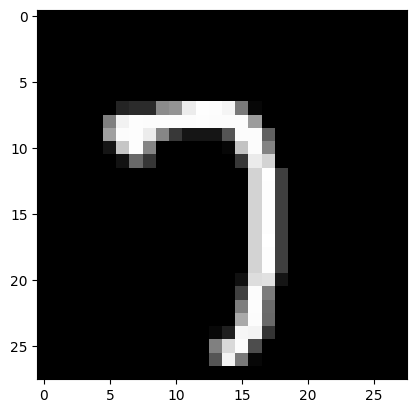

Predicted label: 7


In [83]:
import matplotlib.pyplot as plt
def predict(image):
    '''
    Dự đoán nhãn cho một hình ảnh mới.
    - image là một mảng numpy 2d.
    '''
    out, _, _ = forward(image, 0)  # Sử dụng nhãn 0 vì nhãn không quan trọng trong quá trình dự đoán
    return np.argmax(out)  # Trả về nhãn có xác suất cao nhất


# Chọn một hình ảnh từ tập dữ liệu kiểm tra
image_index = 2700  # bạn có thể thay đổi chỉ số này để xem hình ảnh khác
image = X_test[image_index]

# In ra hình ảnh
plt.imshow(image, cmap='gray')
plt.show()

# Dự đoán nhãn cho hình ảnh
predicted_label = predict(image)
print("Predicted label:", predicted_label)

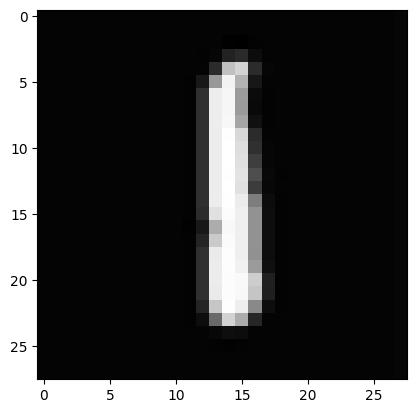

Predicted label: 1


In [85]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


def convert_to_binary(file_path):
    # Open the image file
    with Image.open(file_path) as img:
        # Convert the image to binary (black and white)
        img = img.convert('1')
        return img

def predict(image):
    '''
    Dự đoán nhãn cho một hình ảnh mới.
    - image là một mảng numpy 2d.
    '''
    out, _, _ = forward(image, 0)  # Sử dụng nhãn 0 vì nhãn không quan trọng trong quá trình dự đoán
    return np.argmax(out)  # Trả về nhãn có xác suất cao nhất


def load_image(file_path):
    # Open the image file
    with Image.open(file_path) as img:
        # Convert the image to grayscale
        img = img.convert('L')
        # Invert the colors (black becomes white and vice versa)
        img = ImageOps.invert(img)
        # Resize the image to 28x28
        img = img.resize((28, 28))
        # Convert the image data to a numpy array and return
        return np.array(img)

# Load the image
image_path = 'data/model_1/test_16.png'
image = load_image(image_path)
# In ra hình ảnh
plt.imshow(image, cmap='gray')
plt.show()
# Now you can pass this image to your predict function
predicted_label = predict(image)
print("Predicted label:", predicted_label)

In [86]:
import tkinter as tk
from PIL import ImageGrab, Image, ImageOps
import numpy as np

def load_image(file_path):
    # Open the image file
    with Image.open(file_path) as img:
        # Convert the image to grayscale
        img = img.convert('L')
        # Invert the colors (black becomes white and vice versa)
        img = ImageOps.invert(img)
        # Resize the image to 28x28
        img = img.resize((28, 28))
        # Convert the image data to a numpy array and return
        return np.array(img)

def predict(image):
    out, _, _ = forward(image, 0)  # Use label 0 as label is not important during prediction
    return np.argmax(out)  # Return the label with the highest probability

class DigitRecognizer(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)

        self.canvas = tk.Canvas(self, width=280, height=280, bg='white', cursor='cross')
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.classify_btn = tk.Button(self, text="Recognise", command=self.classify_handwriting)
        self.button_clear = tk.Button(self, text="Clear", command=self.clear_all)

        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky='w', )
        self.label.grid(row=0, column=1, pady=2, padx=2)
        self.classify_btn.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)

        self.canvas.bind("<B1-Motion>", self.draw_lines)

    def clear_all(self):
        self.canvas.delete("all")

    def classify_handwriting(self):
        x = self.winfo_rootx() + self.canvas.winfo_x()
        y = self.winfo_rooty() + self.canvas.winfo_y()
        x1 = x + self.canvas.winfo_width()
        y1 = y + self.canvas.winfo_height()
        im = ImageGrab.grab((x, y, x1, y1))
        im.save("temp.png")  # Save the image temporarily
        image = load_image("temp.png")  # Load the image using the function you provided
        predicted_label = predict(image)  # Predict the label using the function you provided
        self.label.configure(text=str(predicted_label))

    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r = 8
        self.canvas.create_oval(self.x - r, self.y - r, self.x + r, self.y + r, fill='black')

digit_recognizer = DigitRecognizer()
digit_recognizer.mainloop()

KeyboardInterrupt: 